In [1]:
from katsu.polarimetry import full_mueller_polarimetry
from katsu.mueller import linear_polarizer,linear_retarder
import numpy as np

# Dual Rotating Retarder Polarimetry
So you want to measure a Mueller matrix, that's neat. To do so we use the Dual Rotating Retarder Polarimeter (DRRP). This consists of:
- a source
- a linear polarizer at a fixed angle
- a quarter-wave plate that can rotate
- the system you are trying to measure the mueller matrix of
- a quarter-wave plate that can rotate
- a linear polarizer at a fixed angle
- a detector to measure power

The theory of this polarimeter is covered in Chipman, and also Azzam, but is reproduced in brief here. Our first polarizer/waveplate pair forms our *polarization state generator* (PSG). The latter pair forms our *polarization state analyzer* (PSA). The first waveplate must rotate $N_{meas} > 16$ times at some angular step size $\delta\theta$. The second waveplate must also rotate $N_{meas}$ times, but at five times the step size $5\delta\theta$.

For each $\delta\theta$ we record the power on the detector. We next must understand that detectors can only measure power! This means, that it effectively measures the first row of the PSA matrix and the first column of the PSG matrix. The reason for that is revealed in the mueller calculus, which I've left as an exercise to the reader below*

$$\mathbf{S}_{out} = [\mathbf{PSA}] \mathbf{M}_{system} [\mathbf{PSG}] \mathbf{S_{0}}$$

For each measurement iteration we compute our PSA and PSG, and then store those results in our polarimetric data reduction matrix $\mathbf{W}$. This is an $N_{meas} \times 16$ matrix that contains what our PSA and PSG are doing. $\mathbf{W}$ is given by:

$$\mathbf{W} = [\mathbf{PSA}_{0,j}] \otimes [\mathbf{PSG}_{i,0}]$$

Where $i,j$ are the row and column indices, respectively, and $\otimes$ is the Kronecker product. For each measurement, we record the power on the detector and store it in a vector that is $N_{meas}$ long, called $\mathbf{P}$, and we computpe the unraveled mueller matrix using the following relation:

$$\mathbf{M}_{meas} = \mathbf{W}^{-1}\mathbf{P}$$

For the case where $N_{meas} > 16$, you must use the moore-penrose pseudo inverse to invert $\mathbf{W}$. Now that the theory is out of the way, let's test it out!

*aren't I the worst?

In [2]:
# Start by generating a random mueller matrix composed of a polarizer and retarder
M_to_measure = linear_retarder(np.random.random(),np.random.random()) @ linear_polarizer(np.random.random())
display(M_to_measure)

array([[0.5       , 0.49632643, 0.06049853, 0.        ],
       [0.45971012, 0.45633257, 0.05562358, 0.        ],
       [0.11982325, 0.11894289, 0.01449826, 0.        ],
       [0.15591342, 0.15476791, 0.01886507, 0.        ]])

## Performing a simulated measurement
This mode of `full_mueller_polarimetry` uses an internal simulator where the Mueller matrix is known, and is largely useful for 1) making sure the algorithm works and 2) testing the theoretical limits of the technique. We can provide it with the matrix above and it carries out the method described earlier. Let's see how it does! We begin with the minimum number of measurements, 16.

In [3]:
# katsu has a simulator built-in, so let's try use that
thetas = np.linspace(0,np.pi,16) # 16 measurements between 0 and pi
M_out = full_mueller_polarimetry(thetas,Min=M_to_measure)

In [4]:
print('Mueller Matrix Measured')
print(M_out)
print('Percent Difference')
print(100*(M_to_measure-M_out)/M_to_measure)

Mueller Matrix Measured
[[ 5.00000000e-01  4.96326432e-01  6.04985339e-02 -1.76941795e-16]
 [ 4.59710119e-01  4.56332566e-01  5.56235764e-02  5.23886490e-16]
 [ 8.63300195e-02  8.56957412e-02  1.04456792e-02  7.97972799e-17]
 [ 1.72660039e-01  1.71391482e-01  2.08913585e-02  4.51028104e-17]]
Percent Difference
[[-8.88178420e-14 -1.34212843e-13 -1.37634289e-13             inf]
 [-1.56978265e-13 -3.16280283e-13  1.92110923e-12            -inf]
 [ 2.79521965e+01  2.79521965e+01  2.79521965e+01            -inf]
 [-1.07409707e+01 -1.07409707e+01 -1.07409707e+01            -inf]]


<ipython-input-4-f26d43f49149>:4: RuntimeWarning: divide by zero encountered in divide
  print(100*(M_to_measure-M_out)/M_to_measure)


Pardon the rightmost column blowing up, but those were all zeros anyway. We successfully recover some of the information for the top two rows but not the bottom, can this be fixed with more measurements?

In [5]:
# katsu has a simulator built-in, so let's try use that
thetas = np.linspace(0,np.pi,24) # 24 measurements between 0 and pi
M_out = full_mueller_polarimetry(thetas,Min=M_to_measure)
print('Mueller Matrix Measured')
print(M_out)
print('Percent Difference')
print(100*(M_to_measure-M_out)/M_to_measure)

Mueller Matrix Measured
[[ 5.00000000e-01  4.96326432e-01  6.04985339e-02 -1.11022302e-16]
 [ 4.59710119e-01  4.56332566e-01  5.56235764e-02  0.00000000e+00]
 [ 1.19823250e-01  1.18942892e-01  1.44982619e-02 -5.55111512e-17]
 [ 1.55913424e-01  1.54767907e-01  1.88650671e-02  2.08166817e-17]]
Percent Difference
[[ 6.66133815e-14 -8.94752286e-14  1.33046479e-12             inf]
 [-2.05279269e-13  1.45975515e-13 -3.66757217e-12             nan]
 [-4.16947764e-13 -5.83380291e-14 -1.28025975e-12             inf]
 [ 1.24613407e-13  0.00000000e+00  1.37931405e-12            -inf]]


<ipython-input-5-0dd24482ebfc>:7: RuntimeWarning: divide by zero encountered in divide
  print(100*(M_to_measure-M_out)/M_to_measure)
<ipython-input-5-0dd24482ebfc>:7: RuntimeWarning: invalid value encountered in divide
  print(100*(M_to_measure-M_out)/M_to_measure)


Indeed it can! Experimentally I've found that 24 is a good minimum number of measurements to get accurate measurements of the mueller matrix. But you shouldn't trust me yet. Let's start by actually generating a fake dataset.

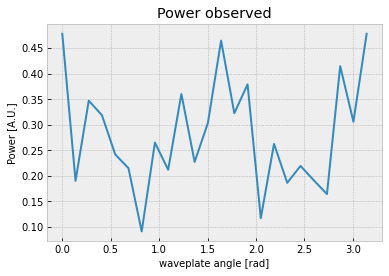

In [6]:
power_matrix = np.zeros_like(thetas)

# this is like building the W matrix
for i,angle in enumerate(thetas):
    PSG = linear_retarder(angle,np.pi/2) @ linear_polarizer(0)
    PSA = linear_polarizer(0) @ linear_retarder(angle*5,np.pi/2)
    power_matrix[i] = (PSA[0,:] @ M_to_measure @ PSG[:,0])

import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure()
plt.title('Power observed')
plt.plot(thetas,power_matrix)
plt.xlabel('waveplate angle [rad]')
plt.ylabel('Power [A.U.]')
plt.show()

Here we can see the observed power as we sweep through the retarder rotation. Instead of providing `full_mueller_polarimetry` with a known mueller matrix, we can just pass it the data that contains the power recorded and let the algorithm figure it out! The result is shown below.

In [10]:
M_out = full_mueller_polarimetry(thetas,power=power_matrix)
print('Mueller Matrix Measured')
print(M_out)
print('Percent Difference')
print(100*(M_to_measure-M_out)/M_to_measure)

Mueller Matrix Measured
[[ 5.00000000e-01  4.96326432e-01  6.04985339e-02 -1.11022302e-16]
 [ 4.59710119e-01  4.56332566e-01  5.56235764e-02  0.00000000e+00]
 [ 1.19823250e-01  1.18942892e-01  1.44982619e-02 -5.55111512e-17]
 [ 1.55913424e-01  1.54767907e-01  1.88650671e-02  2.08166817e-17]]
Percent Difference
[[ 6.66133815e-14 -8.94752286e-14  1.33046479e-12             inf]
 [-2.05279269e-13  1.45975515e-13 -3.66757217e-12             nan]
 [-4.16947764e-13 -5.83380291e-14 -1.28025975e-12             inf]
 [ 1.24613407e-13  0.00000000e+00  1.37931405e-12            -inf]]


<ipython-input-10-813888664ba5>:5: RuntimeWarning: divide by zero encountered in divide
  print(100*(M_to_measure-M_out)/M_to_measure)
<ipython-input-10-813888664ba5>:5: RuntimeWarning: invalid value encountered in divide
  print(100*(M_to_measure-M_out)/M_to_measure)


Success! We can use this algorithm to measure the Mueller matrix of a given detector. At the moment this is a per-pixel calculation, but this can be generalized to N pixels by looping over the pixel index. Broadcasting the calculation is trivial, I just haven't implemented it yet.

## Discussion
We've illustrated the basics of DRRP's and how we can use katsu** to process the data to get a mueller matrix out. There are some limits to what we can do with the existing codebase however, because it is not written for the most general case. A list of assumptions are included below:
- 1) Katsu assumes that the mueller matrix is measured w.r.t. the axis of the linear polarizers as horizontal
- 2) Katsu assumes that the linear polarizers are parallel
- 3) Katsu assumes that the fast-axis of the quarter-wave plates begin parallel to the polarizers
- 4) Katsu operates on scalar powers, meaning that it can only presently process one pixel at a time

These changes are easy to implement, it's just worth noting that they are not present in the codebase yet!

**name preliminary, still thinking of a better one